# Model XGBoost V2

**In this notebook, we are taking the XGBoost v1 and perform further analysis after obtaining the model results to validate that the accuracy of the model is not due to a single column with very high importance**

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import xgboost as xgb  
from sklearn.utils.class_weight import compute_class_weight  
from sklearn.metrics import accuracy_score, classification_report  
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_importance



In [3]:
df = pd.read_parquet('../Data/cleaned_data.parquet')
print(df.head())

            timestamp  label        well              id  P-MON-CKP  \
0 2013-10-04 22:54:00      9  WELL-00020  20131004225400  7817419.0   
1 2013-10-04 22:54:01      9  WELL-00020  20131004225400  7817328.0   
2 2013-10-04 22:54:02      9  WELL-00020  20131004225400  7817236.0   
3 2013-10-04 22:54:03      9  WELL-00020  20131004225400  7817146.0   
4 2013-10-04 22:54:04      9  WELL-00020  20131004225400  7817055.0   

        P-PDG       P-TPT  T-JUS-CKP     T-TPT  class  
0  17077970.0  25102880.0  -10.62551  3.593652    0.0  
1  17077990.0  25103050.0  -10.62626  3.593652    0.0  
2  17078010.0  25103220.0  -10.62700  3.593652    0.0  
3  17078040.0  25103380.0  -10.62774  3.593652    0.0  
4  17078060.0  25103550.0  -10.62848  3.593652    0.0  


In [4]:
# Filter the DataFrame to keep only rows with labels 0, 1, 5, or 7
df = df[df['label'].isin([0, 1, 5, 7])]

# Reset the index if needed
df.reset_index(drop=True, inplace=True)

# Check the results
print(df.info())
print(df['label'].value_counts())  # Verify only the desired labels are included


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35717592 entries, 0 to 35717591
Data columns (total 10 columns):
 #   Column     Dtype         
---  ------     -----         
 0   timestamp  datetime64[us]
 1   label      int64         
 2   well       object        
 3   id         object        
 4   P-MON-CKP  float64       
 5   P-PDG      float64       
 6   P-TPT      float64       
 7   T-JUS-CKP  float64       
 8   T-TPT      float64       
 9   class      float64       
dtypes: datetime64[us](1), float64(6), int64(1), object(2)
memory usage: 2.7+ GB
None
label
5    13301677
1     9089136
7     8619224
0     4707555
Name: count, dtype: int64


In [5]:
# Display unique values in the 'class' column
unique_values = df['class'].unique()

print("Unique values in the 'class' column:")
print(unique_values)


Unique values in the 'class' column:
[  0. 101.   1. 105.   5. 107.   7.]


In [6]:
# Filter the DataFrame to keep only rows with class [0,101,105,107]
df = df[df['class'].isin([0,101,105,107])]

# Reset the index if needed
df.reset_index(drop=True, inplace=True)


In [7]:
#check
# Display unique values in the 'class' column
unique_values = df['class'].unique()

print("Unique values in the 'class' column:")
print(unique_values)


Unique values in the 'class' column:
[  0. 101. 105. 107.]


In [8]:
df = df.drop(columns=['label'], errors='ignore')


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22119280 entries, 0 to 22119279
Data columns (total 9 columns):
 #   Column     Dtype         
---  ------     -----         
 0   timestamp  datetime64[us]
 1   well       object        
 2   id         object        
 3   P-MON-CKP  float64       
 4   P-PDG      float64       
 5   P-TPT      float64       
 6   T-JUS-CKP  float64       
 7   T-TPT      float64       
 8   class      float64       
dtypes: datetime64[us](1), float64(6), object(2)
memory usage: 1.5+ GB


In [25]:


# Features and sequence length
features = ['P-MON-CKP', 'P-PDG', 'P-TPT', 'T-JUS-CKP', 'T-TPT']
sequence_length = 60

# Initialize empty sets to store final IDs for train and test
train_ids = set()
test_ids = set()

# Step 1: Split IDs for `class` 0 separately
class_0_ids = df[df['class'] == 0]['id'].unique()
train_0_ids, test_0_ids = train_test_split(class_0_ids, test_size=0.2, random_state=42)

# Add IDs to respective sets
train_ids.update(train_0_ids)
test_ids.update(test_0_ids)

# Step 2: Split IDs for other classes (`101`, `105`, `107`) separately
class_other_ids = df[df['class'].isin([101, 105, 107])].groupby('class')['id'].unique()

for cls, ids in class_other_ids.items():
    # Filter IDs to exclude any overlap with existing train or test IDs
    ids = np.setdiff1d(ids, list(train_ids.union(test_ids)))
    
    # If there are fewer IDs, handle small splits gracefully
    if len(ids) <= 1:
        # Assign all remaining IDs to the train set for this class
        train_ids.update(ids)
    else:
        # Split the remaining IDs for this class
        train_cls_ids, test_cls_ids = train_test_split(ids, test_size=0.2, random_state=42)

        # Add IDs to respective sets
        train_ids.update(train_cls_ids)
        test_ids.update(test_cls_ids)

# Step 3: Split the DataFrame based on final ID sets
train_df = df[df['id'].isin(train_ids)]
test_df = df[df['id'].isin(test_ids)]

# Step 4: Verify no overlap
assert not train_ids.intersection(test_ids), "Overlap detected between train and test sets!"

# Print sizes of each set and unique class distribution
print(f"Train set size: {len(train_df)} rows, {len(train_ids)} unique IDs")
print(f"Test set size: {len(test_df)} rows, {len(test_ids)} unique IDs")

print("\nClass distribution:")
print("Train class distribution:")
print(train_df['class'].value_counts())
print("\nTest class distribution:")
print(test_df['class'].value_counts())



Train set size: 18135660 rows, 672 unique IDs
Test set size: 3983620 rows, 168 unique IDs

Class distribution:
Train class distribution:
class
107.0    6256217
0.0      5801975
101.0    4094820
105.0    1982648
Name: count, dtype: int64

Test class distribution:
class
0.0      1379665
101.0    1164386
107.0     998850
105.0     440719
Name: count, dtype: int64


In [26]:
# Flatten the data to 2D for XGBoost
def prepare_x_y(df, features):
    X = df[features].values
    y = df['class'].values
    return X, y

# Prepare X and y for train and test datasets
X_train, y_train = prepare_x_y(train_df, features)
X_test, y_test = prepare_x_y(test_df, features)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Map class labels to zero-indexed format
class_mapping = {cls: idx for idx, cls in enumerate(sorted(np.unique(y_train)))}
y_train_mapped = np.array([class_mapping[label] for label in y_train])  # Map y_train to 0-indexed labels
y_test_mapped = np.array([class_mapping[label] for label in y_test])    # Map y_test to 0-indexed labels

# Compute class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_mapped), y=y_train_mapped)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Print class mapping and weights
print("Class mapping (original to sequential):", class_mapping)
print("Class weights (balanced):", class_weights_dict)


Class mapping (original to sequential): {0.0: 0, 101.0: 1, 105.0: 2, 107.0: 3}
Class weights (balanced): {0: 0.7814433878119089, 1: 1.107231819713687, 2: 2.2867977573427054, 3: 0.7247055209242262}


In [27]:

# Define the XGBoost model
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # Softmax for multi-class classification
    num_class=len(class_mapping),  # Number of unique classes
    eval_metric='mlogloss',       # Multi-class log loss
    use_label_encoder=False,      # Avoid label encoder warnings
    n_estimators=100,             # Number of trees
    max_depth=6,                  # Tree depth
    learning_rate=0.1,            # Learning rate
    random_state=42
)

# Train the model without early stopping
xgb_model.fit(
    X_train, y_train_mapped,
    verbose=True
)


/Users/abdulatifalzawawi/Dropbox/Mac/Desktop/anaconda3/envs/clean_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [18:20:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_class=4, num_parallel_tree=None, ...)

In [28]:

# Evaluate the model on the test set
test_accuracy = xgb_model.score(X_test, y_test_mapped)
print(f"Test Accuracy: {test_accuracy:.4f}")  # Format accuracy for better readability

# Reverse mapping for predictions
reverse_class_mapping = {v: k for k, v in class_mapping.items()}  # Reverse the mapping

# Generate predictions
predictions = xgb_model.predict(X_test)

# Map predictions back to original class labels
original_labels = [reverse_class_mapping[pred] for pred in predictions]

# Display sample predictions
print("Sample predictions (original labels):", original_labels[:10])

# Optional: Evaluate further
from sklearn.metrics import classification_report, confusion_matrix

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_mapped, predictions, target_names=[str(reverse_class_mapping[i]) for i in range(len(reverse_class_mapping))]))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_mapped, predictions))


Test Accuracy: 0.9123
Sample predictions (original labels): [105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.84      0.88   1379665
       101.0       0.98      0.95      0.97   1164386
       105.0       0.88      0.98      0.93    440719
       107.0       0.83      0.94      0.88    998850

    accuracy                           0.91   3983620
   macro avg       0.91      0.93      0.91   3983620
weighted avg       0.92      0.91      0.91   3983620


Confusion Matrix:
[[1155768   18379   58206  147312]
 [  11931 1110977       0   41478]
 [  10488       0  429845     386]
 [  61327       0       0  937523]]


In [29]:
# Check unique 'class' values in the train, validation, and test datasets
train_classes = train_df['class'].unique()
test_classes = test_df['class'].unique()

print("Unique 'class' values in training dataset:", train_classes)
print("Unique 'class' values in test dataset:", test_classes)


Unique 'class' values in training dataset: [  0. 101. 105. 107.]
Unique 'class' values in test dataset: [  0. 105. 107. 101.]


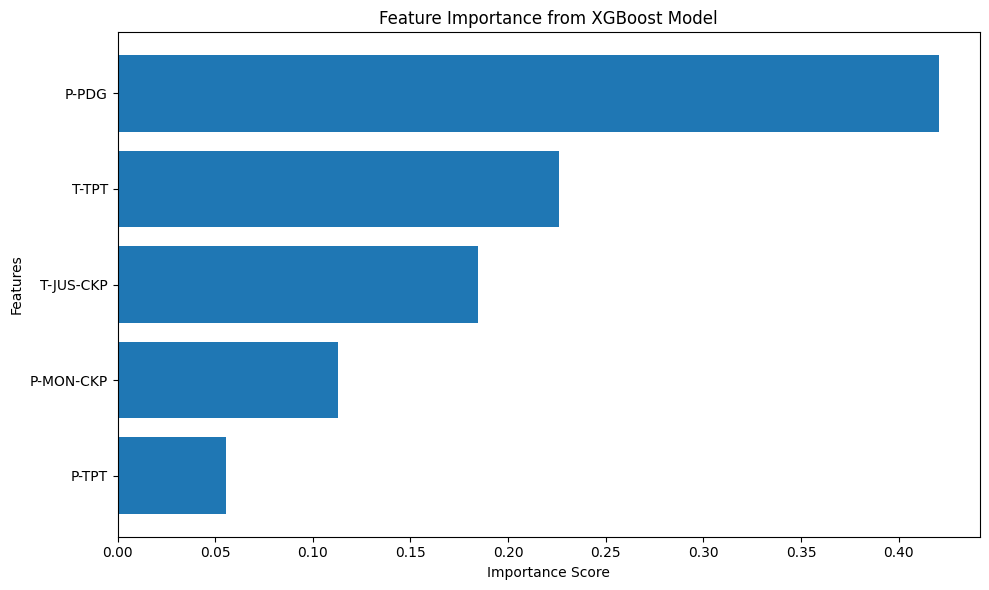

In [17]:
# Extract feature importance
feature_importance = xgb_model.feature_importances_
feature_names = features  # Use the features list from dataset

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], align='center')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance from XGBoost Model')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.tight_layout()
plt.show()



In [19]:
# model without P-PDG

features_without_ppdg = [f for f in features if f != 'P-PDG']
X_train_reduced = train_df[features_without_ppdg]
X_test_reduced = test_df[features_without_ppdg]
xgb_model.fit(X_train_reduced, y_train_mapped)
reduced_accuracy = xgb_model.score(X_test_reduced, y_test_mapped)
print(f"Accuracy without P-PDG: {reduced_accuracy:.4f}")


/Users/abdulatifalzawawi/Dropbox/Mac/Desktop/anaconda3/envs/clean_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [18:12:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy without P-PDG: 0.9120


In [20]:
# full evaluation

# Evaluate the model
reduced_accuracy = xgb_model.score(X_test_reduced, y_test_mapped)
print(f"Accuracy without P-PDG: {reduced_accuracy:.4f}")

# Generate predictions and evaluate further
predictions_reduced = xgb_model.predict(X_test_reduced)

# Classification report
print("\nClassification Report (without P-PDG):")
print(classification_report(y_test_mapped, predictions_reduced, target_names=[str(reverse_class_mapping[i]) for i in range(len(reverse_class_mapping))]))

# Confusion matrix
print("\nConfusion Matrix (without P-PDG):")
print(confusion_matrix(y_test_mapped, predictions_reduced))

Accuracy without P-PDG: 0.9120

Classification Report (without P-PDG):
              precision    recall  f1-score   support

         0.0       0.93      0.84      0.88   1379665
       101.0       0.98      0.95      0.97   1164386
       105.0       0.89      0.98      0.93    440719
       107.0       0.83      0.94      0.88    998850

    accuracy                           0.91   3983620
   macro avg       0.91      0.93      0.92   3983620
weighted avg       0.92      0.91      0.91   3983620


Confusion Matrix (without P-PDG):
[[1156931   19505   55717  147512]
 [  14789 1108119       0   41478]
 [  10013       0  430604     102]
 [  61480       0       0  937370]]
